## Generate figures for paper
* This notebook generates all figures for the manuscript.
* Note that it also performs some important post-processing of the data, particularly the grouping of degenerate modes.
* There are no long-running calculations in this notebook
* Some additional plots are shown which are not included in paper, such as the error in the multipole fit to extinction

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import dill as pickle
import seaborn as sns
import os.path as osp

from scipy.constants import c

In [2]:
savefigs = False

savepath = "."
extension = ".pdf"

def savefigure(filename):
    if savefigs:
        plt.savefig(osp.join(savepath, filename+extension))

### Modify plot settings

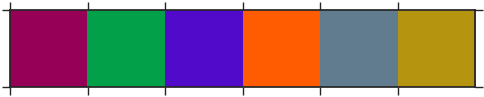

In [3]:
sns.set_style("ticks")

colors = ["dark magenta", "emerald", "violet blue", "bright orange", "blue grey", "dark gold"]
palette_multipoles = sns.xkcd_palette(colors)
sns.palplot(palette_multipoles)

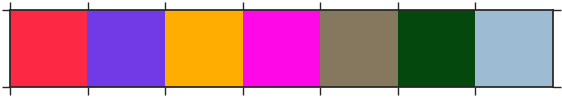

In [4]:
palette_modes = sns.xkcd_palette(["strawberry","bluish purple", "orange yellow", 
                                  "bright magenta", "brownish grey", "british racing green", "light grey blue"])
sns.palplot(palette_modes)

In [5]:
infile = "disk_calculations.pickle"

with open(infile, "rb") as infile:
    data = pickle.load(infile)
print(data.keys())    

dict_keys(['parameters', 'freqs', 'contour', 'a_m', 'a_e', 'sim', 'refined', 'extinction_modes', 'extinction'])


In [6]:
lrange = np.arange(data['a_e'].shape[1])
#multipole_correction = 1 #np.sqrt(2*lrange+1)[None, :, None]

cross_section = np.pi*data['parameters']['radius']**2

a_e = data['a_e'] #*multipole_correction
a_m = data['a_m'] #*multipole_correction
freqs = data['freqs']
sim = data['sim']

In [7]:
extinction = data['extinction']
extinction_modes = data['extinction_modes']
refined = data['refined']
full_modes = refined.add_conjugates()
mode_s = refined.s[0]

## Calculate extinction and scattering from multipoles

In [8]:
# Extinction of each multipole
extinction_ae = np.zeros(a_e.shape[:2], np.complex128)
extinction_am = np.zeros_like(extinction_ae)

scattering_ae = np.zeros(a_e.shape[:2])
scattering_am = np.zeros_like(scattering_ae)

k_range = 2*np.pi*freqs/c

ae_labels = []
am_labels = []

min_l = 1
max_l = 4

for ln in lrange[min_l:max_l]:
    extinction_ae[:, ln] = -1j*np.pi*sum(np.sqrt(2*ln+1)*a_e[:, ln, mn] for mn in [-1, 1])/k_range**2
    extinction_am[:, ln] = -1j*np.pi*sum(np.sqrt(2*ln+1)*mn*a_m[:, ln, mn] for mn in [-1, 1])/k_range**2
    
    scattering_ae[:, ln] = np.pi*sum(np.abs(a_e[:, ln, mn])**2 for mn in range(-ln, ln+1))/k_range**2
    scattering_am[:, ln] = np.pi*sum(np.abs(a_m[:, ln, mn])**2 for mn in range(-ln, ln+1))/k_range**2    
    
    ae_labels.append(r"$a_{%d}$"%(ln))
    am_labels.append(r"$b_{%d}$"%(ln))

### Check how well multipole decomposition reproduces extinction

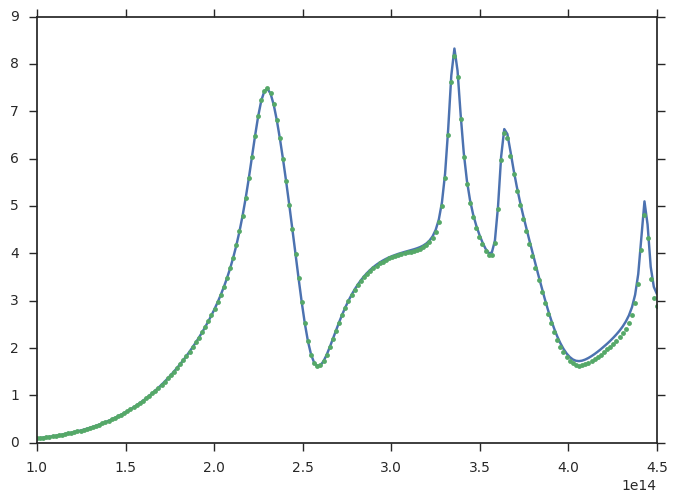

In [9]:
plt.figure()
plt.plot(freqs, extinction.real/cross_section)
plt.plot(freqs, np.sum(extinction_ae+extinction_am, axis=1).real/cross_section, '.')
plt.show()

### Explicitly show relative error in multipole extinction

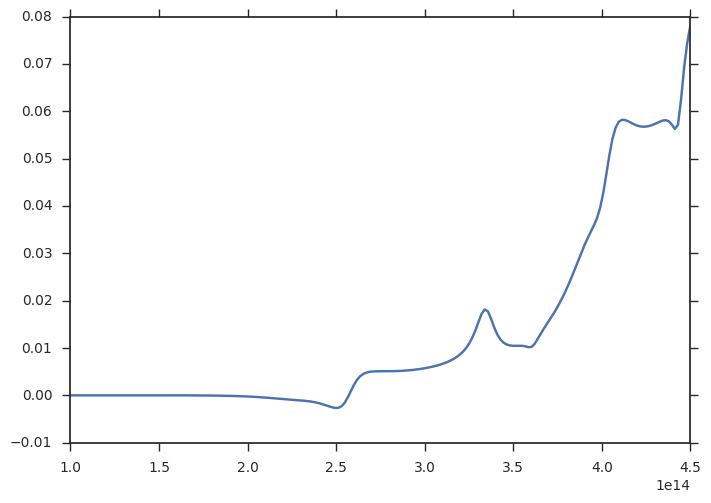

In [10]:
sigma_ext = extinction.real/cross_section
sigma_ext_vsh = np.sum(extinction_ae+extinction_am, axis=1).real/cross_section
sigma_err = sigma_ext-sigma_ext_vsh

plt.figure()
plt.plot(freqs, sigma_err/sigma_ext)
plt.show()

## Plot extinction for each multipole

In [11]:
# axis points for wavelength scale
ticks_nm = np.array([2600, 1900, 1500, 1200, 1000, 900, 800, 700])
ticks_thz2 = c/ticks_nm*1e-3
ticks_thz = [freqs[0]*1e-12, freqs[-1]*1e-12]

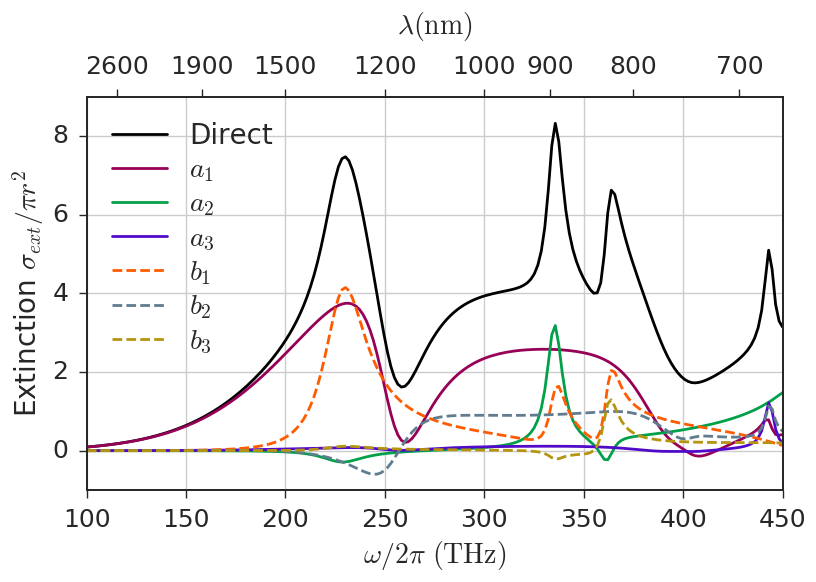

In [12]:
with sns.color_palette(palette_multipoles): 
    fig, ax = plt.subplots()
    fig.subplots_adjust(left=0.1, right=0.97, top=0.84)
    ax.plot(freqs*1e-12, extinction.real/cross_section, 'k-', linewidth=2)
    ax.plot(freqs*1e-12, extinction_ae[:, min_l:max_l].real/cross_section, linewidth=2)
    ax.plot(freqs*1e-12, extinction_am[:, min_l:max_l].real/cross_section, dashes=[7, 3], linewidth=2)
    ax.legend(["Direct"]+ae_labels+am_labels, fontsize=20, loc="upper left", labelspacing=0.2)
    ax.set_xlabel(r'$\omega/2\pi\ \mathrm{(THz)}$', fontsize=20)
    ax.set_ylabel(r'Extinction $\sigma_{ext}/\pi r^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18, right=False, top=False)
    ax.grid()

    ax2 = ax.twiny()
    ax2.grid(False)
    ax2.set_xticks(ticks_thz2)
    ax2.set_xticklabels(ticks_nm)
    ax2.set_xlim(ticks_thz[0], ticks_thz[-1])
    ax2.set_xlabel(r'$\lambda \mathrm{(nm)}$', fontsize=20, labelpad=15)
    ax2.tick_params(axis='both', which='major', labelsize=18)

    savefigure('multipole-extinction')
    plt.show()

## Plot scattering from each multipole

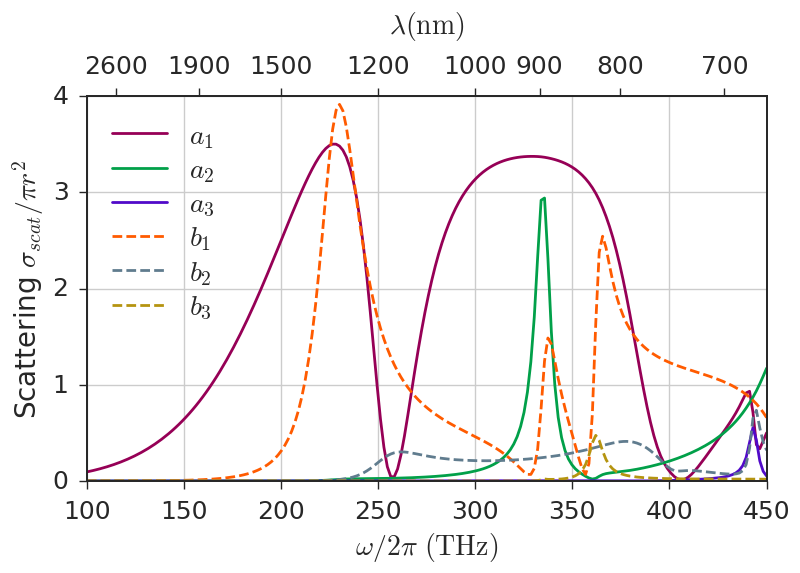

In [13]:
max_l_scat = 4

with sns.color_palette(palette_multipoles): 
    fig, ax = plt.subplots()
    fig.subplots_adjust(left=0.12, right=0.97, top=0.84, bottom=0.14)

    ax.plot(freqs*1e-12, scattering_ae[:, min_l:max_l_scat]/cross_section, linewidth=2)
    ax.plot(freqs*1e-12, scattering_am[:, min_l:max_l_scat]/cross_section, linewidth=2, dashes=[7,3])

    ax2 = ax.twiny()
    ax2.grid(False)
    ax2.set_xticks(ticks_thz2)
    ax2.set_xticklabels(ticks_nm)
    ax2.set_xlim(ticks_thz[0], ticks_thz[-1])
    ax2.set_xlabel(r'$\lambda \mathrm{(nm)}$', fontsize=20, labelpad=15)
    ax2.tick_params(axis='both', which='major', labelsize=18)

    ax.set_xlabel(r'$\omega/2\pi\ \mathrm{(THz)}$', fontsize=20)
    ax.set_ylabel(r'Scattering $\sigma_{scat}/\pi r^2$', fontsize=20)
    ax.legend(ae_labels+am_labels, fontsize=20, loc="upper left", labelspacing=0.2)
    ax.tick_params(axis='both', which='major', labelsize=18, right=False)
    ax.grid(True)
    ax.set_yticks([0, 1, 2, 3, 4])
    savefigure('multipole-scattering')
    plt.show()

## Pick modes of interest for plotting poles and extinction

In [14]:
def group_modes(modes, threshold=1e-2):
    "Group all modes which are degenerate, and which are complex conjugates of each other, within a certain threshold"

    # determine matching for each unique part id
    matched = {}
    for part_id, part_data in modes.modes_of_parts.items():
        s = part_data['s']
        s = s.real + 1j*np.abs(s.imag) # normalise so that conjugate modes get included
        matched[part_id] = []
        unmatched = list(range(len(s)))

        while len(unmatched) > 0:
            current = unmatched.pop()
            ds = np.abs((s[current]-s[unmatched])/s[current])
            matches = np.where(ds < threshold)[0]
            current_group = [current]
            # Traverse in reverse order so that popping does not invalidate other
            # elements
            for m in reversed(matches):
                current_group.append(unmatched[m])
                unmatched.pop(m)
            matched[part_id].append(current_group)
            
    # turn this into a list of mode numbers
    return matched

In [15]:
num_freqs = 200
freqs = np.linspace(100e12, 450e12, num_freqs)

### Combine extinction contribution of degenerate and conjugate modes

In [16]:
grouped_modes = list(group_modes(full_modes, 5e-3).values())[0]
extinction_degen = np.zeros((len(freqs), len(grouped_modes)), np.complex128)

for match_num, match in enumerate(grouped_modes):
    for mode in match:
        extinction_degen[:, match_num] += extinction_modes[:, mode]

significant_groups = np.max(np.abs(extinction_degen.real), axis=0) > 0.2e-12

wanted_modes = []
unwanted_modes = []
wanted_groups = []
import bisect

wanted_extinction = []

for match_num, match in enumerate(grouped_modes):
    if significant_groups[match_num]:
        mode_num = min(match)
        position = bisect.bisect(wanted_modes, mode_num)
        wanted_modes.insert(position, mode_num)
        wanted_groups.insert(position, match)
        wanted_extinction.insert(position, extinction_degen[:, match_num])
    else:
        for mode_num in match:
            # find one mode, with positive imaginary part
            if full_modes.s[:, mode_num].imag > 0:
                unwanted_modes.append(mode_num)
                break

wanted_extinction = np.array(wanted_extinction).T

In [17]:
print(wanted_groups)

[[97, 96, 26, 25], [99, 98, 28, 27], [101, 100, 30, 29], [111, 110, 40, 39], [114, 113, 43, 42], [120, 119, 49, 48], [144, 143, 142, 141, 140, 139, 73, 72, 71, 70, 69, 68]]


In [18]:
len(wanted_groups), len(full_modes)

(7, 145)

## Plot poles and extinction as subplots of the same plot

In [19]:
mode_markers = ['o', 'd', 's', 'p', 'h', '*', '^']

/home/dap124/Documents/code/OpenModes/openmodes/array.py:254: UserWarning: Indexing LookupArray with iterable is unreliable
  warnings.warn("Indexing LookupArray with iterable is unreliable")


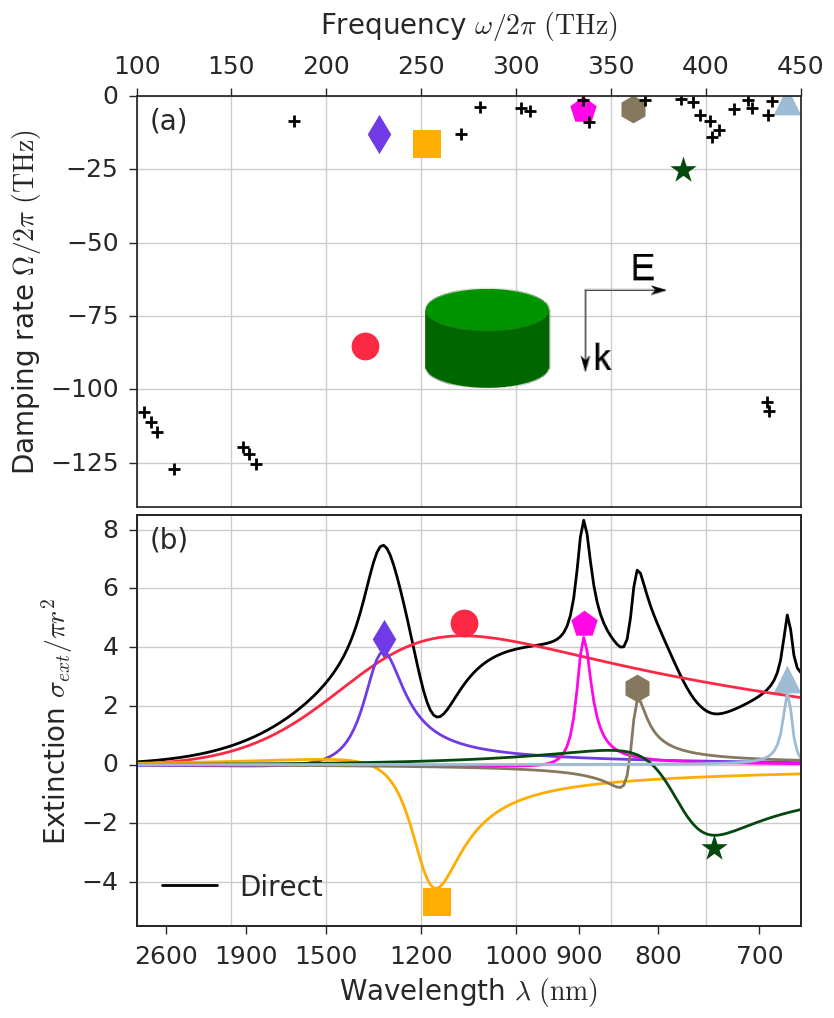

In [20]:
from matplotlib.image import imread

with sns.color_palette(palette_modes):

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(8, 10))
    fig.subplots_adjust(left=0.14, right=0.97, top=0.9, bottom=0.07, hspace=0.02)

    # The upper plot, a scatter plot of the poles
    for mode_count, this_s in enumerate(mode_s[wanted_modes]):
        marker = mode_markers[mode_count]
        colour = palette_modes[mode_count]
        mode_freq = this_s.imag*1e-12/2/np.pi
        ax1.scatter(mode_freq, this_s.real*1e-12/2/np.pi, marker=marker,
                    c=colour, linewidths=0, s=400)
        
        # the marker on the lower curve
        mode_index = np.argmax(np.abs(wanted_extinction[:, mode_count].real))
        mode_x = freqs[mode_index]*1e-12
        mode_y = wanted_extinction[mode_index, mode_count].real/cross_section
        mode_y += 0.45*np.sign(mode_y)
        
        ax2.scatter(mode_x, mode_y, marker=marker,
                    c=colour, linewidths=0, s=400)
        
        
    ax1.scatter(mode_s[unwanted_modes].imag*1e-12/2/np.pi, mode_s[unwanted_modes].real*1e-12/2/np.pi,
                marker='+', c='k', linewidths=2, s=80)
    ax1.set_ylim(-140, 0)
    ax1.set_xlim(100, 450)
    ax1.set_xlabel(r'Frequency $\omega/2\pi\ \mathrm{(THz)}$', fontsize=20, labelpad=15)
    ax1.set_ylabel(r'Damping rate $\Omega/2\pi\ \mathrm{(THz)}$', fontsize=20)
    ax1.tick_params(axis='y', which='major', labelsize=18)
    ax1.text(0.02, 0.92, "(a)", fontsize=20, transform=ax1.transAxes)

    ax1.set_yticks([0, -25, -50, -75, -100, -125])
    ax1.tick_params(bottom=False, right=False, labelsize=18)
    ax1.grid(True)
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top') 

    # Add an inset figure showing polarisation
    ax3 = fig.add_axes([0.5, 0.6, 0.3, 0.15])
    ax3.imshow(imread("inset.png"))
    ax3.axis('off')
    
    # Add an additional X axis giving the wavelength in nm
    ax4 = ax2.twiny()
    ticks_nm = np.array([2600, 1900, 1500, 1200, 1000, 900, 800, 700])
    ticks_thz2 = c/ticks_nm*1e-3    

    ax4.set_xticks(ticks_thz2)
    ax4.set_xticklabels(ticks_nm)
    ax4.set_xlim(ticks_thz[0], ticks_thz[-1])
    
    ax4.set_xlabel(r'Wavelength $\lambda\ \mathrm{(nm)}$', fontsize=20)
    ax4.tick_params(axis='both', which='major', labelsize=18)
    ax4.xaxis.tick_bottom()
    ax4.xaxis.set_label_position('bottom') 

    # The lower plot, a line plot of extinction
    ax2.plot(freqs*1e-12, extinction.real/cross_section, 'k', linewidth=2)
    ax2.plot(freqs*1e-12, wanted_extinction.real/cross_section, linewidth=2)
    ax2.tick_params(top=False, right=False, bottom=False, labelsize=18)
    ax2.text(0.02, 0.92, "(b)", fontsize=20, transform=ax2.transAxes)
   
    ax2.set_xlim(100, 450)
    ax2.grid(True)
    ax2.set_xticklabels([])
    ax2.set_yticks([-4, -2, 0, 2, 4, 6, 8])
    ax2.set_ylim(-5.5, 8.5)
    ax2.set_ylabel(r'Extinction $\sigma_{ext}/\pi r^2$', fontsize=20)
    ax2.legend(["Direct"], fontsize=20, loc="lower left")
   
    savefigure('poles-plus-extinction')
    plt.show()    

## Non-orthogonality between modes

In [21]:
mode_names = ["I", "II", "III", "IV", "V", "VI", "VII"]

In [22]:
wanted_vl = refined.vl.simple_view()[wanted_modes]#.shape
wanted_mag = np.sqrt(np.sum((wanted_vl)**2, axis=1))
wanted_vl /= wanted_mag[:, None]
orth = np.abs(np.dot(wanted_vl, wanted_vl.T))

In [23]:
orth.shape

max_orth = 5

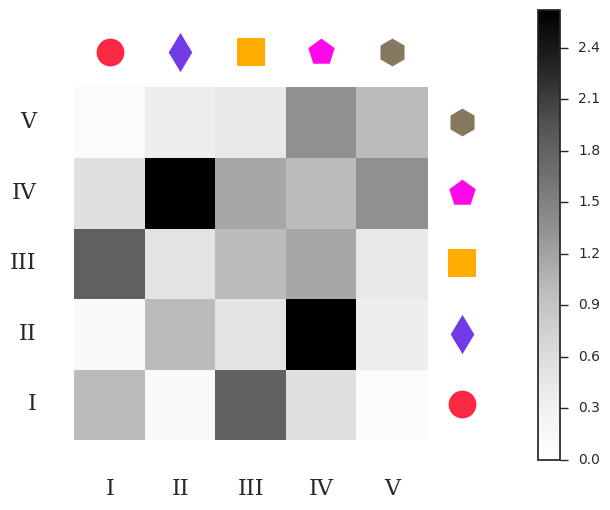

In [24]:
marker_x = np.arange(max_orth)+0.5
marker_y = np.zeros_like(marker_x)+max_orth+0.5

fig, ax = plt.subplots(figsize=(6, 5))
plt.subplots_adjust(right=1.05, top=0.98, left=0.08, bottom=0.08)
pc = ax.pcolor(orth[:max_orth, :max_orth], vmin=0)
fig.colorbar(pc)
for count in range(max_orth):
    ax.scatter(marker_x[count], marker_y[count], c=palette_modes[count],
                marker=mode_markers[count], linewidths=0, s=400)
    ax.scatter(marker_y[count], marker_x[count], c=palette_modes[count],
                marker=mode_markers[count], linewidths=0, s=400)
ax.xaxis.set_ticks(marker_x)
ax.yaxis.set_ticks(marker_x)
ax.xaxis.set_ticklabels(mode_names, fontsize=16, family='serif')
ax.yaxis.set_ticklabels(mode_names, fontsize=16, family='serif')
ax.tick_params(top=False, right=False, bottom=False, left=False)
ax.set_xlim(0, max_orth+1)
ax.set_ylim(0, max_orth+1)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('scaled')

savefigure('mode-overlap')
plt.show()

## Accuracy and convergence

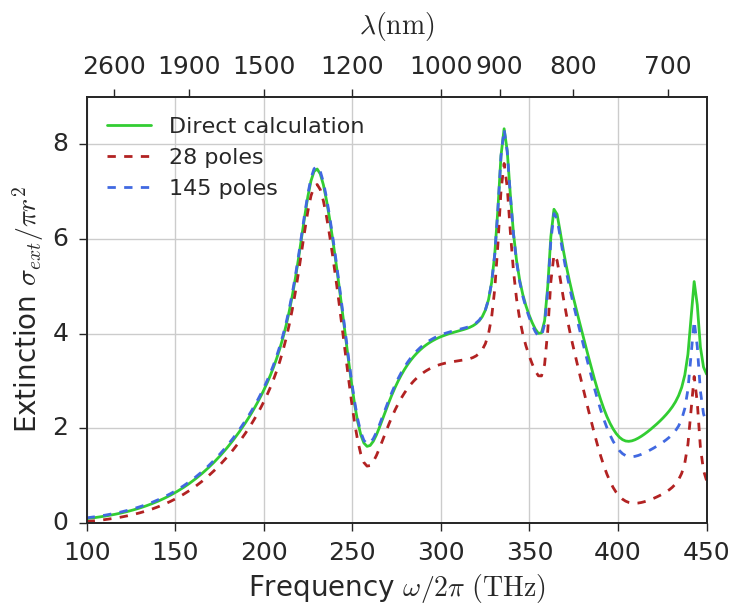

In [25]:
fig, ax = plt.subplots()
ax.plot(freqs*1e-12, extinction.real/cross_section, color='LimeGreen', linewidth=2)
ax.plot(freqs*1e-12, np.sum(wanted_extinction.real/cross_section, axis=1), '--', color='FireBrick', linewidth=2)
ax.plot(freqs*1e-12, np.sum(extinction_modes.real, axis=1)/cross_section, linestyle='--', color='RoyalBlue', linewidth=2)
ax.set_xlabel(r'Frequency $\omega/2\pi\ \mathrm{(THz)}$', fontsize=20)
ax.set_ylabel(r'Extinction $\sigma_{ext}/\pi r^2$', fontsize=20)
plt.legend(["Direct calculation", "28 poles", "145 poles"], fontsize=16, loc="upper left")
ax.tick_params(axis='both', which='major', labelsize=18, right=False)
ax.set_yticks([0, 2, 4, 6, 8])
ax.grid(True)

ax2 = ax.twiny()
ax2.grid(False)
ax2.set_xticks(ticks_thz2)
ax2.set_xticklabels(ticks_nm)
ax2.set_xlim(ticks_thz[0], ticks_thz[-1])
ax2.set_xlabel(r'$\lambda \mathrm{(nm)}$', fontsize=20, labelpad=15)
ax2.tick_params(axis='both', which='major', labelsize=18)

savefigure('modes-accuracy')
plt.show()

## Forward and backward scattering

In [26]:
scat_f = np.empty(num_freqs)
scat_b = np.empty(num_freqs)

num_l = a_e.shape[1]
l = np.arange(num_l)
k = np.empty_like(freqs)

for freq_count, freq in enumerate(freqs):
    k[freq_count] = 2*np.pi*freq/c

    scat_f[freq_count] =  np.abs(sum(sum(np.sqrt(2*ln+1)*(a_e[freq_count, ln, mn] + mn*a_m[freq_count, ln, mn])
                                                for mn in (-1, 1)) for ln in l[1:]))**2/k[freq_count]**2*np.pi/4
    scat_b[freq_count] =  np.abs(sum(sum(np.sqrt(2*ln+1)*(-1)**ln*(a_e[freq_count, ln, mn] - mn*a_m[freq_count, ln, mn])
                                            for mn in (-1, 1)) for ln in l[1:]))**2/k[freq_count]**2*np.pi/4

In [27]:
total_scattering = np.sum(scattering_ae+scattering_am, axis=(1))

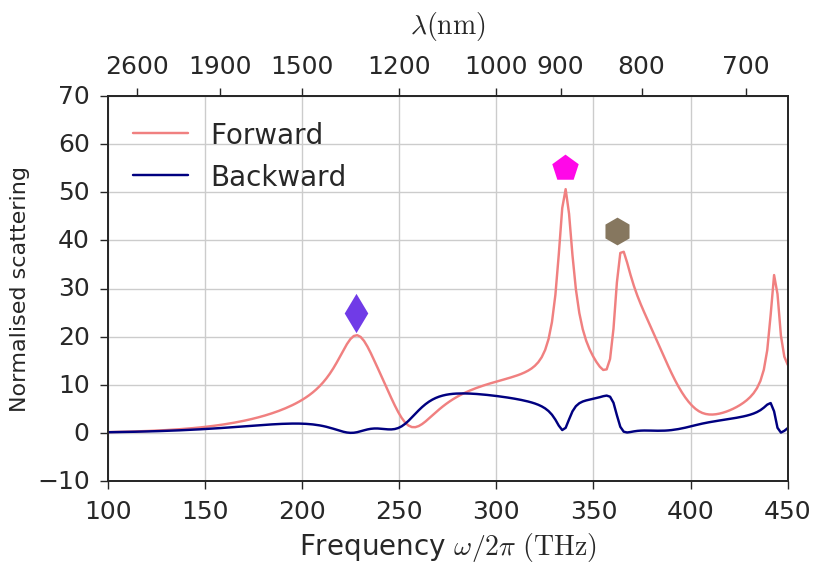

In [28]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=0.12, right=0.97, top=0.84, bottom=0.14)

ax.plot(freqs*1e-12, scat_f/cross_section, color='LightCoral')
ax.plot(freqs*1e-12, scat_b/cross_section, color='Navy')
ax.set_xlabel(r'Frequency $\omega/2\pi\ \mathrm{(THz)}$', fontsize=20)
ax.set_ylabel('Normalised scattering', fontsize=16)
ax.legend(["Forward", "Backward"], fontsize=20, loc="upper left")
ax.tick_params(axis='both', which='major', labelsize=18, right=None)
ax.set_xlim(100, 450)
ax.grid(True)

magnetic_modes = [1, 3, 4]
poles_y = [25, 55, 42]

for which_mode, pole_y in zip(magnetic_modes, poles_y):
    pole_x = mode_s[wanted_modes[which_mode]].imag*1e-12/2/np.pi
    ax.scatter(pole_x, pole_y, marker=mode_markers[which_mode], c = palette_modes[which_mode], linewidths=0, s=400)

ax2 = ax.twiny()
ax2.grid(False)
ax2.set_xticks(ticks_thz2)
ax2.set_xticklabels(ticks_nm)
ax2.set_xlim(ticks_thz[0], ticks_thz[-1])
ax2.set_xlabel(r'$\lambda \mathrm{(nm)}$', fontsize=20, labelpad=15)
ax2.tick_params(axis='both', which='major', labelsize=18)

savefigure('directional-scattering')
plt.show()

## Plot the contour integration

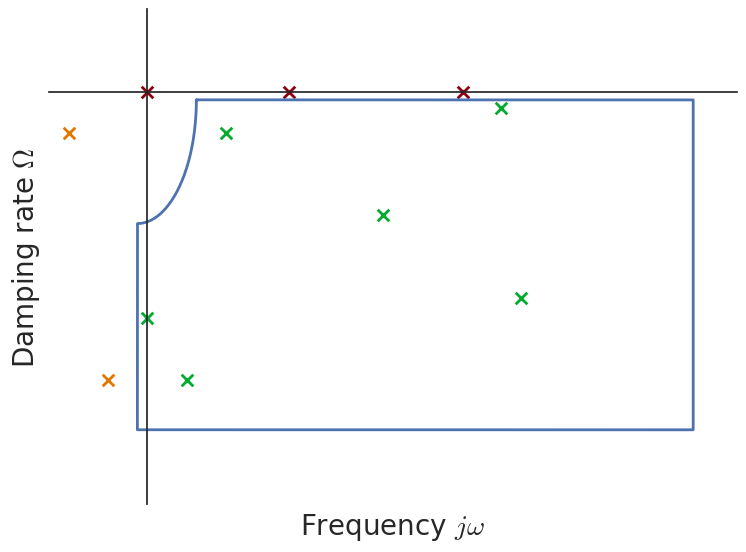

In [29]:
# exaggerate the offsets in the contour for plotting purposes
contour = np.array([p for p, w in data['contour']])*1e-12-20-50j

with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.subplots_adjust(right=0.96, left=0.1, top=1, bottom=0.1)
    plt.plot(contour.imag, contour.real, linewidth=2)
    plt.scatter([0, 720, 1607], [0, 0, 0], marker='x', linewidth=2, s=70, c=sns.xkcd_rgb['crimson'])
    plt.scatter([0, 400, 1200, 200, 1800, 1900], -np.array([550, 100, 300, 700, 40, 500]),
                marker='x', linewidth=2, s=70, c=sns.xkcd_rgb['kelly green'])
    plt.scatter([-400, -200], -np.array([100, 700]),
                marker='x', linewidth=2, s=70, c=sns.xkcd_rgb['pumpkin'])
    ax.spines['top'].set_position('zero')
    ax.spines['right'].set_position('zero')
    ax.tick_params(direction='inout')
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xlim(-500, 3000)
    plt.xlabel(r'Frequency $j\omega$', fontsize=20)
    plt.ylabel(r'Damping rate $\Omega$', fontsize=20)
    plt.yticks([])
    plt.xticks([])
    plt.tick_params(axis='both', which='major', labelsize=18)

    savefigure('contour')
    plt.show()

## Plotting mode currents/surface fields along with multipole decomposition

In [30]:
import matplotlib.gridspec as gridspec

def plot_current_multipoles(current, s, num_multipoles, image, marker_colour, marker, mode_name, filename=None):
    a_e, a_m = sim.multipole_decomposition(current, num_multipoles, s)

    a_e_list = np.zeros(num_multipoles+1)
    a_m_list = np.zeros_like(a_e_list)

    lrange = np.arange(num_multipoles+1)
    
    for l in lrange[1:]:        
        # normalise to scattering contribution
        for m in range(-l, l+1):
            a_e_list[l] += np.abs(a_e[l, m])**2#*(2*l+1)
            a_m_list[l] += np.abs(a_m[l, m])**2#*(2*l+1)

    max_element = np.sum(a_e_list)+np.sum(a_m_list)
    
    a_e_list /= max_element
    a_m_list /= max_element

    a_e_list = np.sqrt(np.abs(a_e_list))
    a_m_list = np.sqrt(np.abs(a_m_list))

    width = 0.6
    ind = np.arange(1, len(a_e_list))

    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[6,4])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 1])
    ax3 = plt.subplot(gs[:, 0])
    
    fig.subplots_adjust(left=-0.02, right=0.98, wspace=0.05, bottom=0.15, top=0.99, hspace=0.05)
    
    electric_colours = palette_multipoles[0] #:3]
    magnetic_colours = palette_multipoles[1] #3:]
    bars_elec = ax1.bar(ind-0.5*width, a_e_list[1:], width, color=electric_colours,
                        label="electric", edgecolor=electric_colours, linewidth=0)
    bars_mag = ax2.bar(ind-0.5*width, a_m_list[1:], width, color=magnetic_colours,
                       label="magnetic", edgecolor=magnetic_colours, linewidth=0)
    
    ax1.text(0.6, 0.7, "Electric", horizontalalignment='left',
      verticalalignment='bottom',
      transform=ax1.transAxes, fontsize=24)
    ax2.text(0.6, 0.7, "Magnetic", horizontalalignment='left',
      verticalalignment='bottom',
      transform=ax2.transAxes, fontsize=24)
    ax2.set_xlabel("Multipole order $l$", fontsize=20)
    ax1.set_ylabel("$|a|$", fontsize=24)
    ax2.set_ylabel("$|b|$", fontsize=24)

    ax1.xaxis.set_ticks([])
    ax2.xaxis.set_ticks(lrange[1:])
    
    for ax in ax1, ax2:
        ax.yaxis.set_ticks([]) #[0, 1])
        ax.set_ylim(0, 1)
        ax.set_xlim(0.5, num_multipoles+0.5)
        ax.yaxis.tick_right()
    
        ax.tick_params(top=False, right=True, left=False, labelsize=18)

    ax3.imshow(imread(image))
    ax3.scatter(0, 0, s=800, c=marker_colour, marker=marker, linewidths=0)
    ax3.annotate(mode_name, (120, 27), fontsize=24, family='serif')
    ax3.axis('off')
    
    savefigure(filename)
    plt.show()

### Produce a single current vector for a given a set of degenerate and conjugate modes
Construct a model based on all of these modes, solve the currents at the imaginary part of resonant frequency for positive $\omega_n$

In [31]:
from openmodes.sources import PlaneWaveSource
pw = PlaneWaveSource([1, 0, 0], [0, 0, 1], p_inc=1.0)

from openmodes.model import ModelMutualWeight

def group_current(modes, group, source):
    part = modes.parent_part
    s = 1j*np.abs(modes.s[0, group[0]].imag)
    
    which_modes = modes.select(group)
    model = ModelMutualWeight(which_modes)
    V = sim.source_vector(source, s, parent=part)
    V_modes = which_modes.vl.dot(V)
    Z = model.impedance(s)
    I_modes = Z.solve(V_modes)
    I = which_modes.vr.dot(I_modes)
    return I, s
        

## Export the mode currents
These currents are in .vtk format, which can be read by the open-source program [ParaView](http://www.paraview.org/). This program is used to generate a .png image of each set of each mode's current.

In [32]:
for count, group in enumerate(wanted_groups):
    I, s = group_current(full_modes, group, pw)
    filename = "disk-modes-{:02d}.vtp".format(count)
    if savefigs:
        sim.plot_3d(solution=I, output_format='vtk', filename=filename)

After the .vtk files have been processed by ParaView to produce .png files, these are loaded back into the notebook to produce a fully annotated figure with currents and multipole expansion

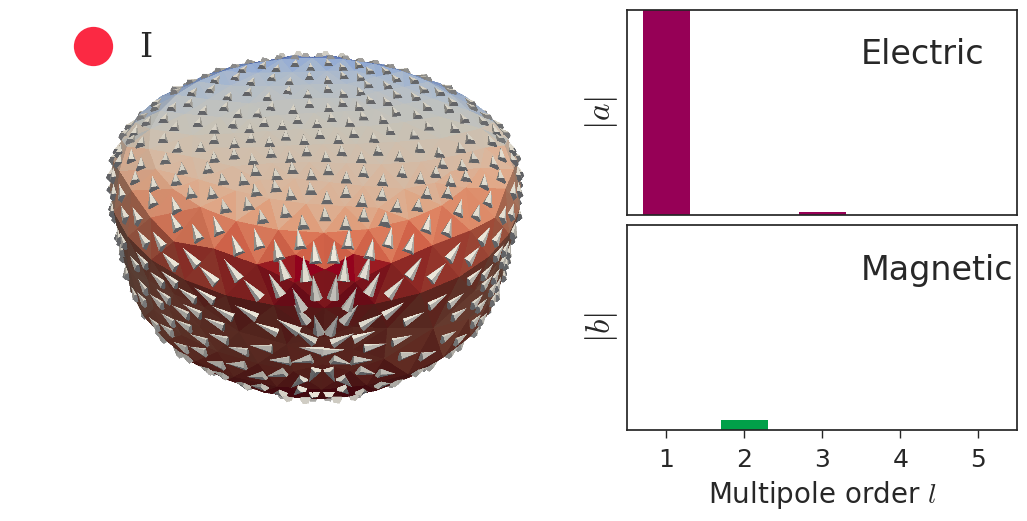

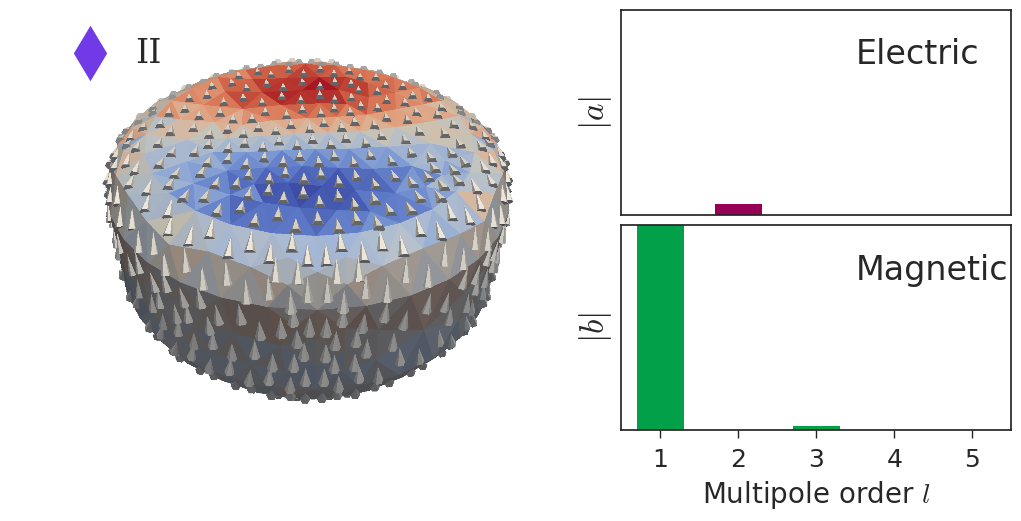

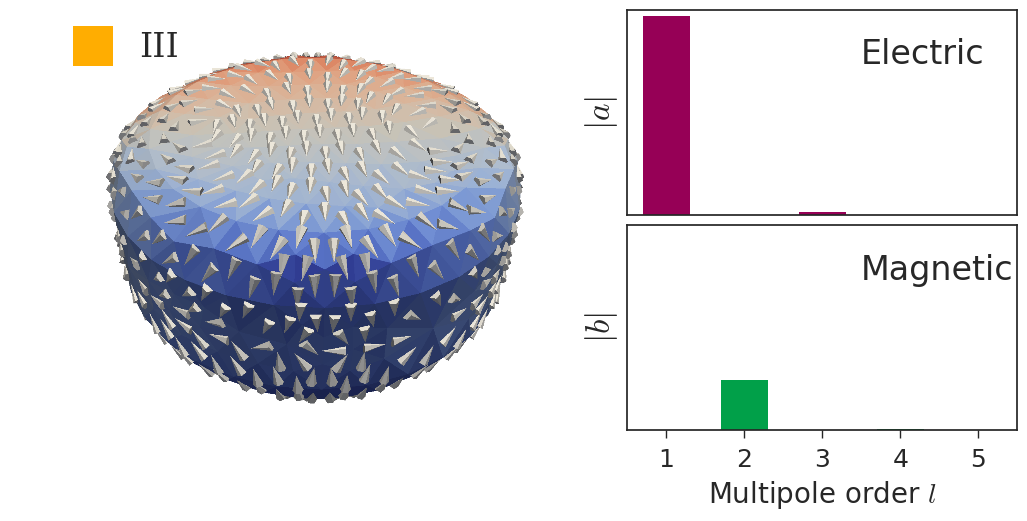

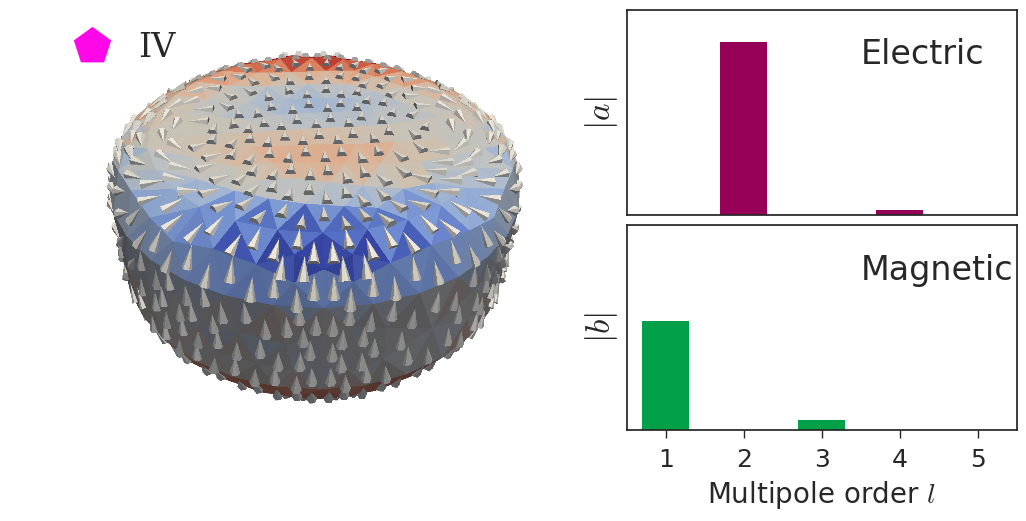

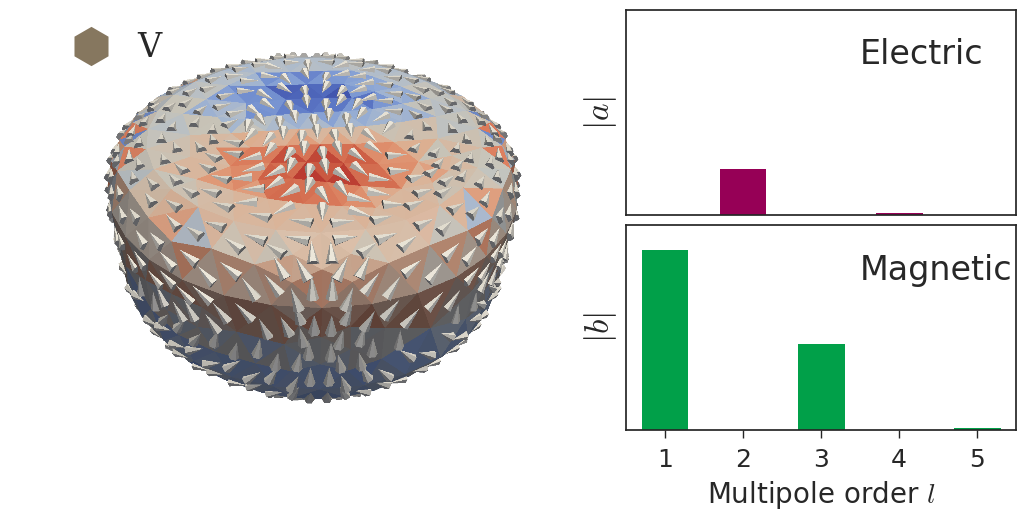

In [33]:
images = ["mode-{}.png".format(n) for n in range(5)]

for count, (group, image, mode_name) in enumerate(zip(wanted_groups, images, mode_names)):
    I, s = group_current(full_modes, group, pw)
    filename = "combined-{:02d}".format(count)
    plot_current_multipoles(I, s, 5, image, palette_modes[count], mode_markers[count], mode_name, filename=filename)